In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
# 1. Load the datasets
# Note: In an actual implementation, you would provide file paths to your datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (4209, 378)
Test data shape: (4209, 377)


In [23]:
# 2. Exploring the data
# Check for null values
print("\nNull values in train set:\n", train_df.isnull().sum().sum())
print("Null values in test set:\n", test_df.isnull().sum().sum())

# Display information about the datasets
print("\nTrain data info:")
print(train_df.info())

print("\nTest data info:")
print(test_df.info())

# Check for unique values in both datasets
print("\nUnique values in train set by column:")
for col in train_df.columns:
    print(f"{col}: {train_df[col].nunique()}")

print("\nUnique values in test set by column:")
for col in test_df.columns:
    print(f"{col}: {test_df[col].nunique()}")


Null values in train set:
 0
Null values in test set:
 0

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB
None

Unique values in train set by column:
ID: 4209
y: 2545
X0: 47
X1: 27
X2: 44
X3: 7
X4: 4
X5: 29
X6: 12
X8: 25
X10: 2
X11: 1
X12: 2
X13: 2
X14: 2
X15: 2
X16: 2
X17: 2
X18: 2
X19: 2
X20: 2
X21: 2
X22: 2
X23: 2
X24: 2
X26: 2
X27: 2
X28: 2
X29: 2
X30: 2
X31: 2
X32: 2
X33: 2
X34: 2
X35: 2
X36: 2
X37: 2
X38: 2
X39: 2
X40: 2
X41: 2
X42: 2
X43: 2
X44: 2
X45: 2
X46: 2
X47: 2
X48: 2
X49: 2
X50: 2
X51: 2
X52: 2
X53: 2
X54: 2
X55: 2
X56: 2
X57: 2
X58: 2
X59: 2
X60: 2
X61: 2
X62: 2
X63: 2
X64: 2
X65: 2
X66: 2
X67: 2
X68: 2
X69: 2
X70: 2
X71: 2
X73: 2
X74: 2
X75: 2
X76: 2


In [24]:
# 3. Preprocessing
# Extract ID and target columns
train_ID = train_df['ID']
y_train = train_df['y']
test_ID = test_df['ID']

# Remove ID and target columns from features
X_train = train_df.drop(['ID', 'y'], axis=1)
X_test = test_df.drop(['ID'], axis=1)


In [25]:
# 4. Remove zero variance features
# Calculate variance for each column
zero_variance_cols = []

for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col]):
        if X_train[col].var() == 0:
            zero_variance_cols.append(col)

print(f"\nNumber of zero variance columns: {len(zero_variance_cols)}")
print("Zero variance columns:", zero_variance_cols)

# Remove zero variance columns
X_train = X_train.drop(zero_variance_cols, axis=1)
X_test = X_test.drop(zero_variance_cols, axis=1)


Number of zero variance columns: 12
Zero variance columns: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


In [26]:
# 5. Apply Label Encoding to categorical features
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        # Fit on both train and test to ensure all categories are represented
        combined_data = pd.concat([X_train[col], X_test[col]])
        le.fit(combined_data)
        
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

print("\nData after label encoding:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



Data after label encoding:
X_train shape: (4209, 364)
X_test shape: (4209, 364)


In [27]:
# 6. Perform dimensionality reduction using PCA
# First, standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Find optimal number of components
# Start with a higher number of components and analyze explained variance
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nReduced from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]} features")
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")


Reduced from 364 to 148 features
Explained variance ratio: 0.9500


In [ ]:
# 7. Train XGBoost model with hyperparameter tuning
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_pca, y_train, 
                                    scoring="neg_mean_squared_error", cv=5))
    return rmse

# Parameters for XGBoost
params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda': [0.01, 0.1, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# Random search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    n_iter=20,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the random search model
random_search.fit(X_train_pca, y_train)

print("\nBest hyperparameters:")
print(random_search.best_params_)

# Train the model with best parameters
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train_pca, y_train)

# Evaluate the model on training data
y_train_pred = best_xgb.predict(X_train_pca)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print(f"\nTraining RMSE: {rmse_train:.6f}")
print(f"Training R² Score: {r2_train:.6f}")


Submission file created successfully!


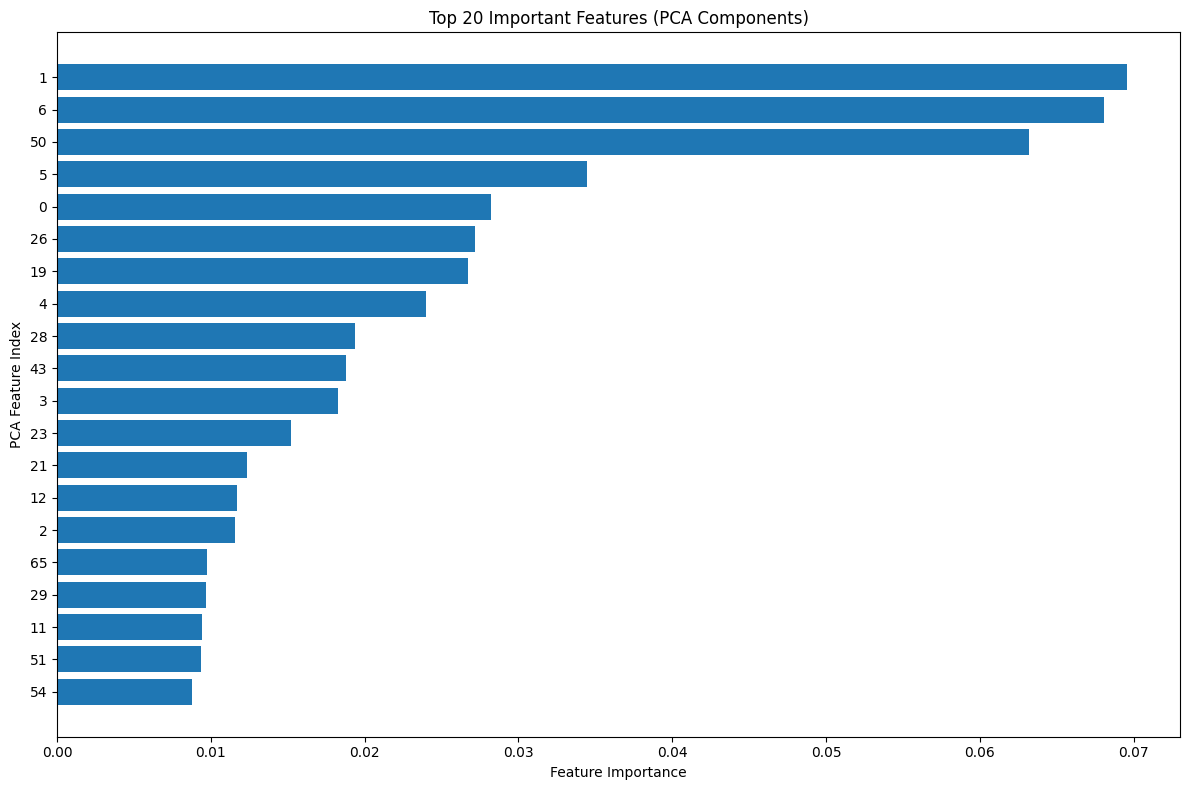

In [19]:
# 8. Make predictions on test data
y_test_pred = best_xgb.predict(X_test_pca)

# 9. Create submission file
submission = pd.DataFrame({
    'ID': test_ID,
    'y': y_test_pred
})

submission.to_csv('mercedes_submission.csv', index=False)

print("\nSubmission file created successfully!")

# 10. Feature importance analysis
plt.figure(figsize=(12, 8))
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(range(X_train_pca.shape[1]))[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('PCA Feature Index')
plt.title('Top 20 Important Features (PCA Components)')
plt.tight_layout()
plt.savefig('feature_importance.png')

# 11. Learning curves for model analysis
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


Analysis complete! Check the generated plots for more insights.


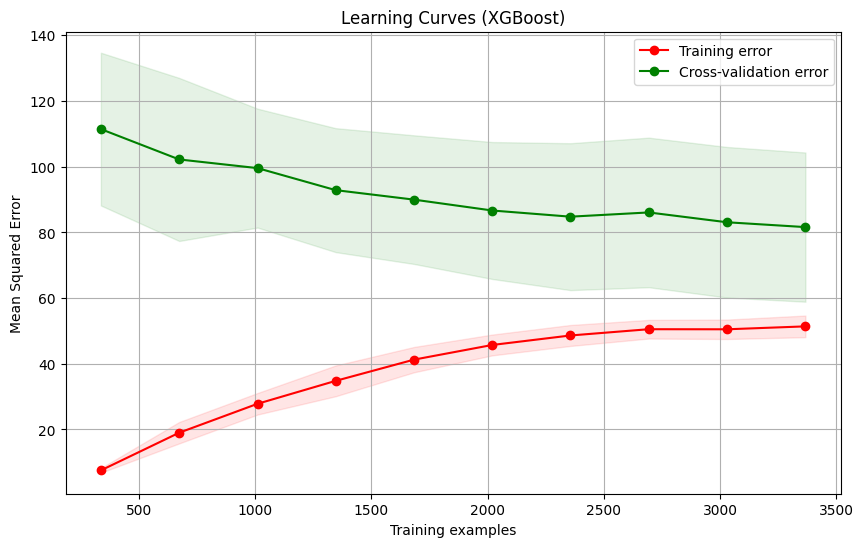

In [20]:
plt.figure(figsize=(10, 6))
plt.title('Learning Curves (XGBoost)')
plt.xlabel('Training examples')
plt.ylabel('Mean Squared Error')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation error')
plt.legend(loc='best')
plt.savefig('learning_curves.png')

print("\nAnalysis complete! Check the generated plots for more insights.")